# YOLOV8关键点检测-预测源码解读-预处理+后处理

同济子豪兄、东哥Talk 2023-5-14

## 导入工具包

In [2]:
import cv2
import numpy as np

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
%matplotlib inline

## 载入模型

AutoBackend源码：`site-packages/ultralytics/nn/autobackend.py`

In [3]:
from ultralytics.nn.autobackend import AutoBackend

In [4]:
model = AutoBackend(weights='Triangle_215_yolov8l_pretrain.pt',
                    device=device,
                    dnn=False,                   # 是否将 OpenCV 的 DNN 库用于推理
                    data='Triangle_215.yaml',
                    fp16=False,
                    fuse=True,
                    verbose=False)

_ = model.eval()

YOLOv8l-pose summary (fused): 287 layers, 44457390 parameters, 0 gradients, 168.5 GFLOPs


In [ ]:
# model

## 载入图像

In [5]:
img_path = 'triangle_4.jpg'

In [6]:
# 导入 BGR 格式的图像
img_bgr = cv2.imread(img_path)

# BGR 转 RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [7]:
img_rgb.shape

(3712, 5568, 3)

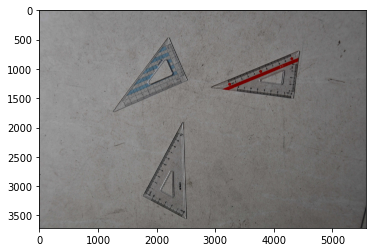

In [8]:
plt.imshow(img_rgb)
plt.show()

## 预处理-缩放图像尺寸

In [9]:
imgsz = [640, 640]

In [10]:
from ultralytics.yolo.data.augment import LetterBox
pre_transform_result = LetterBox(new_shape=imgsz, auto=True)(image=img_rgb)

In [11]:
pre_transform_result.shape

(448, 640, 3)

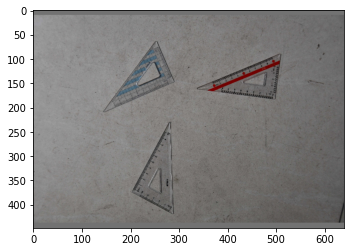

In [12]:
plt.imshow(pre_transform_result)
plt.show()

## 预处理-归一化

In [13]:
input_tensor = pre_transform_result / 255

## 预处理-构造输入张量

In [14]:
input_tensor = np.expand_dims(input_tensor, axis=0) # 加 Batch 维度
input_tensor = input_tensor.transpose((0, 3, 1, 2)) # N, C, H, W
input_tensor = np.ascontiguousarray(input_tensor)   # 将内存不连续存储的数组，转换为内存连续存储的数组，使得内存访问速度更快
input_tensor = torch.from_numpy(input_tensor).to(device).float() # 转 Pytorch Tensor
# input_tensor = input_tensor.half() # 是否开启半精度，即 uint8 转 fp16，默认转 fp32 

In [16]:
input_tensor.shape

torch.Size([1, 3, 448, 640])

## 执行推理预测

In [17]:
preds = model(input_tensor)

## 解析预测结果

In [18]:
len(preds)

2

In [19]:
preds[0].shape

torch.Size([1, 14, 5880])

In [20]:
len(preds[1])

2

In [21]:
len(preds[1][0])

3

In [22]:
preds[1][0][0].shape

torch.Size([1, 65, 56, 80])

In [23]:
preds[1][0][1].shape

torch.Size([1, 65, 28, 40])

In [24]:
preds[1][0][2].shape

torch.Size([1, 65, 14, 20])

In [25]:
preds[1][1].shape

torch.Size([1, 9, 5880])

## 后处理-置信度阈值过滤、非极大值抑制NMS过滤

In [26]:
from ultralytics.yolo.utils import ops

In [27]:
pred = ops.non_max_suppression(preds, conf_thres=0.25, iou_thres=0.7, nc=1)[0]

In [28]:
pred.shape

torch.Size([3, 15])

## 解析目标检测预测结果

In [29]:
# 将缩放之后图像的预测结果，投射回原始尺寸
pred[:, :4] = ops.scale_boxes(pre_transform_result.shape[:2], pred[:, :4], img_bgr.shape).round()
pred_det = pred[:, :6].cpu().numpy()

In [30]:
# 目标检测预测结果：左上角X、左上角Y、右下角X、右下角Y、置信度、类别ID
pred_det

array([[       1216,         435,        2546,        1762,     0.96564,           0],
       [       2894,         656,        4440,        1534,      0.9498,           0],
       [       1740,        1903,        2542,        3587,     0.92867,           0]], dtype=float32)

In [31]:
num_bbox = len(pred_det)
print('预测出 {} 个框'.format(num_bbox))

预测出 3 个框


In [32]:
# 类别
bboxes_cls = pred_det[:, 5]

In [33]:
bboxes_cls

array([          0,           0,           0], dtype=float32)

In [34]:
# 置信度
bboxes_conf = pred_det[:, 4]

In [35]:
bboxes_conf

array([    0.96564,      0.9498,     0.92867], dtype=float32)

In [36]:
# 目标检测框 XYXY 坐标
bboxes_xyxy = pred_det[:, :4].astype('uint32')

In [37]:
bboxes_xyxy

array([[1216,  435, 2546, 1762],
       [2894,  656, 4440, 1534],
       [1740, 1903, 2542, 3587]], dtype=uint32)

## 解析关键点检测预测结果

In [38]:
# 将缩放之后图像的预测结果，投射回原始尺寸
pred_kpts = pred[:, 6:].view(len(pred), model.kpt_shape[0], model.kpt_shape[1])
pred_kpts = ops.scale_coords(pre_transform_result.shape[:2], pred_kpts, img_bgr.shape)

In [39]:
pred_kpts.shape

torch.Size([3, 3, 3])

In [40]:
pred_kpts.cpu().numpy()

array([[[     1200.1,      1766.1,     0.95639],
        [     2169.1,      457.59,     0.97127],
        [     2581.4,      1231.3,     0.98524]],

       [[     2943.1,      1321.8,     0.96951],
        [     4462.9,      646.42,     0.97383],
        [     4357.1,      1464.5,     0.98592]],

       [[     2482.2,      1963.4,     0.99597],
        [     2483.7,      3524.5,     0.96909],
        [     1782.1,      3162.5,     0.99055]]], dtype=float32)

In [41]:
bboxes_keypoints = pred_kpts.cpu().numpy().astype('uint32')

In [42]:
bboxes_keypoints

array([[[1200, 1766,    0],
        [2169,  457,    0],
        [2581, 1231,    0]],

       [[2943, 1321,    0],
        [4462,  646,    0],
        [4357, 1464,    0]],

       [[2482, 1963,    0],
        [2483, 3524,    0],
        [1782, 3162,    0]]], dtype=uint32)

## OpenCV可视化关键点

In [43]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 6                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':4,         # 字体大小
    'font_thickness':10,   # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-80,        # Y 方向，文字偏移距离，向下为正
}

In [44]:
# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'angle_30', 'color':[255, 0, 0], 'radius':40},      # 30度角点
    1:{'name':'angle_60', 'color':[0, 255, 0], 'radius':40},      # 60度角点
    2:{'name':'angle_90', 'color':[0, 0, 255], 'radius':40},      # 90度角点
}

# 点类别文字
kpt_labelstr = {
    'font_size':4,             # 字体大小
    'font_thickness':10,       # 字体粗细
    'offset_x':30,             # X 方向，文字偏移距离，向右为正
    'offset_y':120,            # Y 方向，文字偏移距离，向下为正
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[196, 75, 255], 'thickness':12},        # 30度角点-60度角点
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[180, 187, 28], 'thickness':12},        # 30度角点-90度角点
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[47,255, 173], 'thickness':12},         # 60度角点-90度角点
]

In [45]:
for idx in range(num_bbox): # 遍历每个框
    
    # 获取该框坐标
    bbox_xyxy = bboxes_xyxy[idx] 
    
    # 获取框的预测类别（对于关键点检测，只有一个类别）
    bbox_label = 'sjb_rect'
    
    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)
    
    # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
    img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])
    
    bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度
    
    # 画该框的骨架连接
    for skeleton in skeleton_map:
        
        # 获取起始点坐标
        srt_kpt_id = skeleton['srt_kpt_id']
        srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
        srt_kpt_y = bbox_keypoints[srt_kpt_id][1]
        
        # 获取终止点坐标
        dst_kpt_id = skeleton['dst_kpt_id']
        dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
        dst_kpt_y = bbox_keypoints[dst_kpt_id][1]
        
        # 获取骨架连接颜色
        skeleton_color = skeleton['color']
        
        # 获取骨架连接线宽
        skeleton_thickness = skeleton['thickness']
        
        # 画骨架连接
        img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)
        
    # 画该框的关键点
    for kpt_id in kpt_color_map:
        
        # 获取该关键点的颜色、半径、XY坐标
        kpt_color = kpt_color_map[kpt_id]['color']
        kpt_radius = kpt_color_map[kpt_id]['radius']
        kpt_x = bbox_keypoints[kpt_id][0]
        kpt_y = bbox_keypoints[kpt_id][1]
        
        # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
        img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)
        
        # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        # kpt_label = str(kpt_id) # 写关键点类别 ID
        kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称
        img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])

## 可视化预测结果

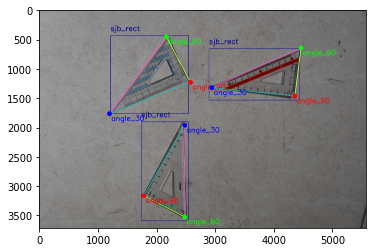

In [46]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()